In [1]:
import matplotlib.pyplot as plt
import DMK_go_coude as Fns
import numpy as np
import os, readcol
import scipy.optimize as optim
import scipy.interpolate as interp
import pickle

from astropy.io import fits 
from mpfit import mpfit
from scipy import signal

%matplotlib inline

In [2]:
dir = os.getenv("HOME") + '/Research/YMG/coude_data/20140321/'
rdir = dir + 'reduction/'
#codedir = os.getenv("HOME") + '/codes/tullcoude/'
codedir = os.getenv("HOME") + '/Research/Codes/coudereduction/'

In [3]:
os.chdir(dir)

In [4]:
DarkCurVal = 0.0

InfoFile = 'headstrip.csv'
FileInfo = readcol.readcol( InfoFile, fsep = ',', asRecArray = True )
DarkCube = FileInfo.ExpTime * DarkCurVal

In [5]:
BiasInds = np.where( FileInfo.Type == 'zero' )[0]
FlatInds = np.where( FileInfo.Type == 'flat' )[0]
ArcInds  = np.where( (FileInfo.Type == 'comp') & ( (FileInfo.Object == 'Thar') | (FileInfo.Object == 'THAR') | (FileInfo.Object == 'A') ) )[0]
ObjInds  = np.where( (FileInfo.Type == 'object') & (FileInfo.Object != 'SolPort') & (FileInfo.Object != 'solar port') & (FileInfo.Object != 'solar_ort') )[0]

In [6]:
CalsDone = True
SuperBias, FlatField = Fns.Basic_Cals( FileInfo.File[BiasInds], FileInfo.File[FlatInds], CalsDone, rdir, plots = False )

Reading in premade Bias and Flat files


In [7]:
ShowBPM = False
BPM = Fns.Make_BPM( SuperBias, FlatField, 99.9, ShowBPM )

In [8]:
RdNoise  = FileInfo.rdn[ArcInds] / FileInfo.gain[ArcInds]
DarkCur  = DarkCube[ArcInds] / FileInfo.gain[ArcInds]
ArcCube, ArcSNR = Fns.Make_Cube( FileInfo.File[ArcInds], RdNoise, DarkCur, Bias = SuperBias )

RdNoise  = FileInfo.rdn[ObjInds] / FileInfo.gain[ObjInds]
DarkCur  = DarkCube[ObjInds] / FileInfo.gain[ObjInds]
ObjCube, ObjSNR = Fns.Make_Cube( FileInfo.File[ObjInds], RdNoise, DarkCur, Bias = SuperBias, Flat = FlatField, BPM = BPM )

DMK_go_coude.py:131: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
DMK_go_coude.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
DMK_go_coude.py:132: RuntimeWarning: divide by zero encountered in divide
DMK_go_coude.py:132: RuntimeWarning: invalid value encountered in divide
/Users/boydrummer94/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [9]:
OrderStart = -32
TraceDone = True
MedCut = 95.0
MedTrace, FitTrace = Fns.Get_Trace( FlatField, ObjCube, OrderStart, MedCut, rdir, TraceDone, plots = False )

Reading in premade Trace and plotting on Flat:


In [10]:
#fullspec, fullsig_spec = Fns.extractor( ObjCube, ObjSNR, FitTrace, quick = False, nosub = False, arc = False )

In [11]:
spec     = pickle.load(open(rdir+'extracted_spec_oldway.pkl','rb'))
sig_spec = pickle.load(open(rdir+'extracted_sigspec_oldway.pkl','rb'))
wspec     = pickle.load(open(rdir+'extracted_wspec_oldway.pkl','rb'))
sig_wspec = pickle.load(open(rdir+'extracted_sigwspec_oldway.pkl','rb'))

In [12]:
wspec      = wspec[:,::-1,:]
sig_wspec  = sig_wspec[:,::-1,:]
spec       = spec[:,::-1,:]
sig_spec   = sig_spec[:,::-1,:]

In [17]:
#This is finding peaks using the scipy signal routine
#peakind = signal.find_peaks_cwt( np.log10(wspec[0,startorder,:]), np.arange( 1, 50 ) )
#print len( np.log10(wspec[0,startorder,:]) )
#print len( np.arange( 1, 50 ) )
#
#plt.clf()
#plt.plot( np.log10(wspec[0,startorder,:]), 'k-' )
#for peak in peakind:
#    plt.axvline( x = peak, color = 'r' )
#plt.show()

In [18]:
THAR      = fits.open( codedir + 'thar_photron.fits' )[0]
THARhead  = THAR.header
THARspec  = THAR.data
THARwav   = np.arange( len( THARspec ) ) * THARhead['CDELT1'] + THARhead['CRVAL1']
THARlines = readcol.readcol( codedir + 'ThAr_list.txt', asRecArray = True )

#qwe            = np.where((THARwav >= np.min(roughwav-10)) & (THARwav <= np.max(roughwav+10)))[0] 
#ls             = THARspec[qwe] - np.min(THARspec[qwe])
#region         = np.where(ls < np.median(ls))
#ls[region]     = np.median(ls)

Removing 1 rows that don't match most common length 2.                       
4168 rows read into array.


In [19]:
roughdisp  = 7000.0 / 60000.0 / 2.0
wavestart  = 6957.0
startorder = wspec.shape[1] - 15 - 1
arcspec    = wspec[0,startorder,:]
roughwav   = wavestart + roughdisp * np.arange( len( arcspec ) )

arcspec           = arcspec - np.min( arcspec )
belowmed          = np.where( arcspec < np.median( arcspec ) )
arcspec[belowmed] = np.median( arcspec )
logarcspec        = np.log10( arcspec )
logarcspec        = logarcspec - np.min( logarcspec )

In [20]:
#newspec = np.log10(norder) - np.min(np.log10(norder))
#thresh = np.percentile( newspec, 97 )
#above  = np.where( newspec >= thresh )[0]

In [21]:
def Gaussian( x, A, mean, sigma, const ):
    gauss = A * np.exp( - ( x - mean ) ** 2.0 / ( 2.0 * sigma ** 2 ) ) + const
    return gauss
    #return np.log10( gauss )

In [22]:
def find_peaks( wav, spec, pwidth = 10, plevel = 97, minsep = 1 ):
    ##given a slice of wavecal spectrum, find line peaks above some significance level    
    fluxthresh  = np.percentile( spec, plevel )
    abovethresh = np.where( spec >= fluxthresh )[0]
    
    peaks = np.array([])
    
    for i in range( len( abovethresh ) ):
        left    = np.max( [abovethresh[i] - pwidth, 0] )
        right   = np.min( [abovethresh[i] + pwidth, len(spec) - 1] )
        maxspot = np.argmax( spec[left:right] )
        maxspot = maxspot + abovethresh[i] - pwidth
        peaks   = np.append( peaks, maxspot.astype(int) )

    peaks = np.unique( peaks ).astype( int )

    ## offset from start/end of array by at least same number of pixels
    peaks   = peaks[peaks > pwidth]
    peaks   = peaks[peaks < ( len(spec) - pwidth )]
    pixcent = np.array([])
    wavcent = np.array([])
    
    ## for each peak, fit a gaussian to find center
    for peak in peaks:

        xi = wav[peak - pwidth:peak + pwidth]
        yi = spec[peak - pwidth:peak + pwidth]
        
        pguess = [ np.nanmax( yi ), float( np.nanargmax( yi ) ), 2.0, np.median( spec ) ]
        
        try:
            params, pcov = optim.curve_fit( Gaussian, np.arange(len(xi), dtype='float'), yi, p0 = pguess )

            ## the gaussian center of the line in pixel units
            pixval  = peak - pwidth + params[1]
            pixcent = np.append( pixcent, pixval )
            ## and the peak in wavelength units
            #wavcent = np.append( wavcent, xi[np.nanargmax(yi)] )
            ceiling = np.ceil( pixval ).astype(int)
            floor   = np.floor( pixval ).astype(int)
            slope   = ( wav[ceiling] - wav[floor] ) / ( ceiling - floor )
            wavval  = wav[floor] + slope * ( pixval - floor )
            wavcent = np.append( wavcent, wavval )
            
        except RuntimeError:
            pixcent = np.append( pixcent, float('nan') )
            wavcent = np.append( wavcent, float('nan') )

    wavcent, wavdup = np.unique( wavcent, return_index = True )
    pixcent = pixcent[wavdup]
    notnan  = np.where( np.isfinite( pixcent ) )
    wavcent = wavcent[notnan]
    pixcent = pixcent[notnan]
    vals = spec[pixcent.astype(int)]
    oks  = np.zeros(len(pixcent),int)+1

    ##now make sure nothing is closer than minsep in wavelength units
    for i in range(len(wavcent)):
        dist = np.absolute(wavcent - wavcent[i])
        close = np.where(dist <= minsep)[0]
        small = np.where(vals[close] < np.max(vals[close]))[0]
        if len(small) != 0: oks[close[small]] = -1
    keep = np.where(oks == 1)
    pixcent = pixcent[keep]
    wavcent = wavcent[keep]
    
    return pixcent, wavcent

In [26]:
print THARthisord[15]
print matched

7000.8036
[ 6960.25    6965.4307  6989.6553  6992.2126  6999.6238  7018.5675
  7030.2514  7045.797   7061.3942  7068.7358  7071.0942]


In [24]:
pixcent, wavcent = find_peaks( roughwav, logarcspec, plevel = 97 )

In [61]:
thisorder   = [ np.min(roughwav), np.max(roughwav) ]
THARthisord = [ line for line in THARlines.wav if line > thisorder[0] and line < thisorder[1] ]

matched = np.zeros( len( wavcent ) )
for i in range( len( wavcent ) ):
    dists      = np.absolute( THARlines.wav - wavcent[i] )
    mindist    = np.argmin( dists )
    line       = THARlines.wav[mindist]
    matched[i] = line
    
wavparams1 = np.polyfit( pixcent, matched, 3 )
wavsol1    = np.polyval( wavparams1, np.arange( len( arcspec ) ) )

#newwavcent = np.polyval( wavparams1, pixcent )
#plt.plot( matched, newwavcent - matched, 'ko' )
#plt.show()
print matched
print np.round(THARthisord,3)

[ 6960.25    6965.4307  6989.6553  6992.2126  6999.6238  7018.5675
  7030.2514  7045.797   7061.3942  7068.7358  7071.0942]
[ 6960.25   6962.312  6965.431  6969.298  6981.083  6985.472  6986.03
  6989.655  6992.213  6992.697  6993.037  6993.987  6996.757  6999.271
  6999.624  7000.804  7002.883  7007.096  7014.969  7015.317  7018.568
  7020.484  7021.283  7025.225  7026.462  7028.023  7030.251  7032.931
  7033.359  7033.652  7036.283  7038.72   7045.797  7053.62   7054.418
  7055.901  7058.49   7059.525  7060.042  7060.654  7061.394  7064.452
  7067.218  7068.736  7071.094  7071.48   7072.394  7074.256  7075.334]


8510.19129879


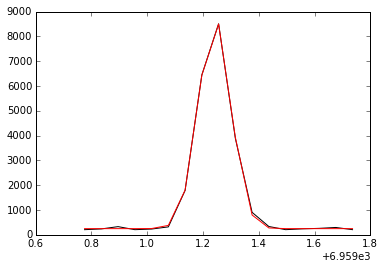

In [64]:
linetest = 0
testwavs = [ wav for wav in wavsol1 if wav >= THARthisord[linetest] - 0.5 and wav <= THARthisord[linetest] + 0.5 ]
testinds = [ np.where( wavsol1 == wav )[0][0] for wav in testwavs ]

pguess = [ 1000, testwavs[np.argmax(arcspec[testinds])], 0.1, 0 ]
params, pcov = optim.curve_fit( Gaussian, testwavs, arcspec[testinds], p0 = pguess )
fit = Gaussian( testwavs, params[0], params[1], params[2], params[3] )
print params[0]

plt.plot( testwavs, arcspec[testinds], 'k-' )
plt.plot( testwavs, Gaussian(testwavs, params[0], params[1], params[2], params[3] ), 'r-' )
plt.show()

##### 

In [ ]:
matched = np.zeros( len( wavcent ) )
for i in range( len( wavcent ) ):
    dists   = np.absolute( THARlines.wav - wavcent[i] )
    mindist = np.argmin( dists )
    line    = THARlines.wav[mindist]
    matched[i] = line

In [ ]:
matched

In [ ]:
pixcent

In [ ]:
wavparams = np.polyfit( pixcent, matched, 3 )
wavsol    = np.polyval( wavparams, np.arange( len( arcspec ) ) )

In [ ]:
wavsol[np.floor(pixcent).astype(int)]

In [ ]:
plt.clf()
plt.plot( THARwav, np.log10(THARspec), 'k-' )
plt.plot( wavsol, logarcspec, 'r-' )
plt.xlim( 6955, 7080 )
plt.show()

In [ ]:
values = np.linspace( 0, 1000, 10000 ) # This is the equivalent of your Mpeak/Mv
counts = [] # This is initializing an empty array for the N > each value

# Loop through each of the values
for value in values:
    N = 0 # Initialize the N>value to 0, will add to it
    for x in values: # Now loop through each value again
        if x > value:
            N += 1 # If it is greater than add to the counter
    counts.append( N )
plt.plot( values, counts, 'k-' )
plt.show()